In [2]:
!pip install soundfile

In [10]:
!pip install pydub


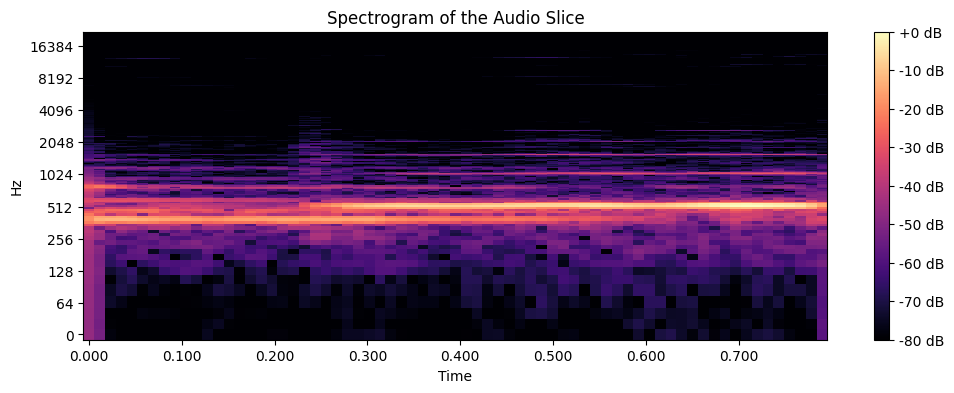

In [23]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# Load a specific slice of audio from a file
audio_path = '/content/original.mpeg'  # Make sure to replace this with your actual audio file path
start_time = 0.4  # Start at 0.4 seconds
end_time = 1.2    # End at 1.2 seconds
sr = None         # Use the native sampling rate

# Load the audio file slice
audio, sr = librosa.load(audio_path, sr=sr, offset=start_time, duration=end_time - start_time)

# Calculate the short-time Fourier transform (STFT) for visualization
D = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)

# Plotting the STFT of the audio slice
plt.figure(figsize=(12, 4))
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of the Audio Slice')
plt.show()


# **1. Pitch Estimation and Manipulation**

In [4]:
import numpy as np
import librosa

def autocorrelation_pitch_estimation(audio, sr):
    # Calculate autocorrelation
    autocorr = np.correlate(audio, audio, mode='full')
    autocorr = autocorr[len(autocorr)//2:]

    # Find the first peak after the zero lag peak
    peak_index = np.argmax(autocorr[1:]) + 1
    pitch_period = float(sr) / peak_index
    pitch_frequency = 1 / (pitch_period / sr)

    return pitch_frequency

# Example usage
audio_file_path = "/content/original.mpeg"
try:
    # Load the .mp3 file, resampling to 22050 Hz
    audio, sr = librosa.load(audio_file_path, sr=22050, duration=1.2, offset=0.4)
    print("Audio file loaded successfully!")
except FileNotFoundError:
    print("Audio file not found. Please check the path.")
except Exception as e:
    print(f"An error occurred: {e}")
pitch_frequency = autocorrelation_pitch_estimation(audio, sr)
print("Estimated Pitch Frequency:", pitch_frequency)


Audio file loaded successfully!
Estimated Pitch Frequency: 1.0


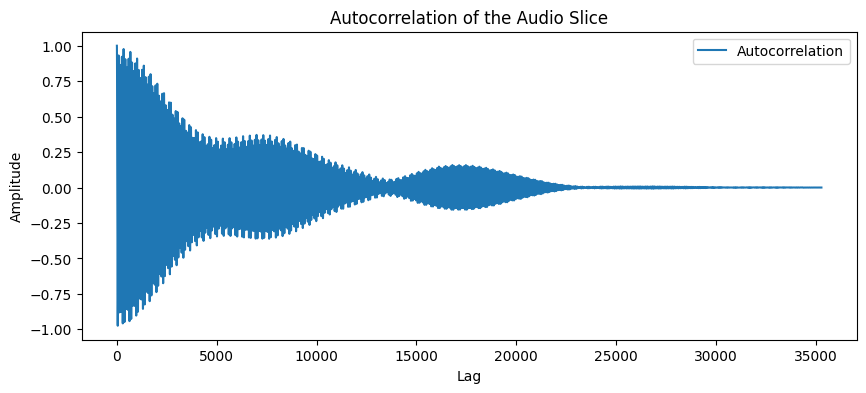

In [33]:
import numpy as np
import librosa
import matplotlib.pyplot as plt

def autocorrelation_pitch_estimation(audio, sr):
    # Calculate autocorrelation
    autocorr = np.correlate(audio, audio, mode='full')
    autocorr = autocorr[len(autocorr)//2:]  # Keep only the second half
    autocorr /= np.max(autocorr)  # Normalize

    # Find the first peak in the autocorrelation beyond the zero lag
    zero_lag_index = len(audio) - 1
    # Make sure there is a region to search
    if len(autocorr) > zero_lag_index + 1:
        possible_peaks = autocorr[zero_lag_index + 1:]
        if np.any(possible_peaks > 0.1):  # Check there are peaks above a threshold level
            first_peak = np.argmax(possible_peaks > 0.1)
            peak_index = zero_lag_index + 1 + first_peak
            pitch_period = sr / peak_index
            pitch_frequency = sr / pitch_period
        else:
            pitch_frequency = 0  # No significant peak found
            peak_index = None
    else:
        pitch_frequency = 0  # No data to analyze beyond zero lag
        peak_index = None

    return pitch_frequency, autocorr, peak_index

# Load the audio file slice
audio_path = '/content/original.mpeg'
start_time = 0.4  # Start time in seconds
end_time = 1.2    # End time in seconds
audio, sr = librosa.load(audio_path, sr=None, offset=start_time, duration=end_time - start_time)

# Perform pitch estimation
pitch_frequency, autocorr, peak_index = autocorrelation_pitch_estimation(audio, sr)

# Plotting the autocorrelation with the identified peak, if a peak was found
plt.figure(figsize=(10, 4))
plt.plot(autocorr, label='Autocorrelation')
if peak_index is not None:
    plt.plot(peak_index, autocorr[peak_index], 'ro', label=f'Pitch Frequency: {pitch_frequency:.4f} Hz')
else:
    plt.title('No significant pitch detected')
plt.title('Autocorrelation of the Audio Slice')
plt.xlabel('Lag')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


# **2. FFT for Pitch Estimation**

In [5]:
import numpy as np
import librosa

def fft_pitch_estimation(audio, sr):
    # Perform FFT
    fft_spectrum = np.fft.rfft(audio)
    freqs = np.fft.rfftfreq(len(audio), d=1/sr)

    # Find the peak in the FFT spectrum
    peak_index = np.argmax(np.abs(fft_spectrum))
    pitch_frequency = freqs[peak_index]

    return pitch_frequency

# Example usage
audio, sr = librosa.load(audio_file_path, sr=None, duration=1.2, offset=0.4)
pitch_frequency = fft_pitch_estimation(audio, sr)
print("Estimated Pitch Frequency:", pitch_frequency)


Estimated Pitch Frequency: 523.3333333333334


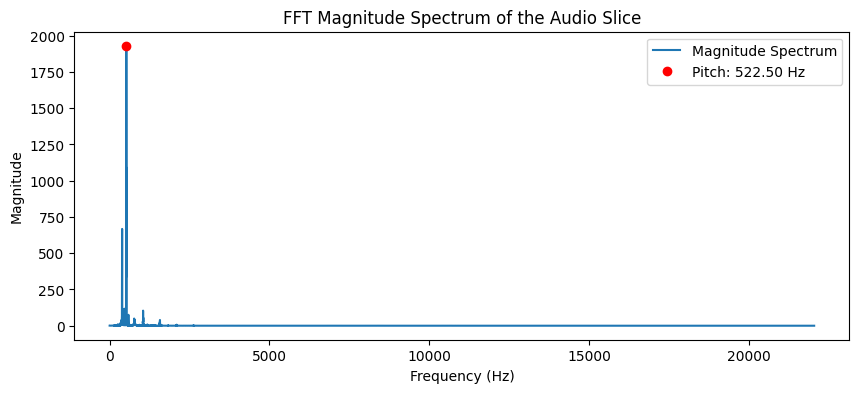

In [27]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

def fft_pitch_estimation(audio, sr):
    # Compute FFT
    fft_spectrum = np.fft.rfft(audio)
    frequencies = np.fft.rfftfreq(len(audio), d=1/sr)

    # Magnitude spectrum
    magnitude = np.abs(fft_spectrum)

    # Find the peak in the magnitude spectrum
    peak_index = np.argmax(magnitude)
    fundamental_frequency = frequencies[peak_index]

    return fundamental_frequency, frequencies, magnitude

# Load the audio file slice
audio_path = '/content/original.mpeg'
start_time = 0.4  # Start time in seconds
end_time = 1.2    # End time in seconds
audio, sr = librosa.load(audio_path, sr=None, offset=start_time, duration=end_time - start_time)

# Perform FFT pitch estimation
fundamental_frequency, frequencies, magnitude = fft_pitch_estimation(audio, sr)

# Plotting the FFT magnitude spectrum
plt.figure(figsize=(10, 4))
plt.plot(frequencies, magnitude, label='Magnitude Spectrum')
plt.plot(fundamental_frequency, magnitude[frequencies == fundamental_frequency][0], 'ro', label=f'Pitch: {fundamental_frequency:.2f} Hz')
plt.title('FFT Magnitude Spectrum of the Audio Slice')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')
plt.legend()
plt.show()

# **3. LPC for Pitch Estimation**

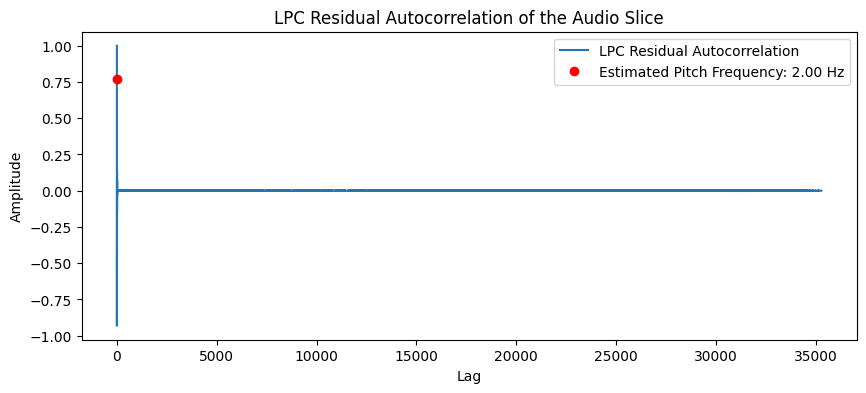

In [41]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import scipy.signal as signal

def lpc_pitch_estimation(audio, sr, order=16):
    # LPC analysis
    lpc_coeffs = librosa.lpc(audio, order=order)
    # Filter the signal with the LPC filter to get the residual
    residual = signal.lfilter(lpc_coeffs, [1], audio)

    # Autocorrelation of the residual
    autocorr = np.correlate(residual, residual, mode='full')
    autocorr = autocorr[len(autocorr)//2:]

    # Normalize autocorrelation for easier peak detection
    autocorr /= np.max(autocorr)

    # Find the first significant peak after the zero-lag peak
    d = np.diff(autocorr)
    start = np.argmax(d > 0)  # Start where the difference goes positive
    peak_index = np.argmax(autocorr[start:]) + start
    pitch_period = float(sr) / peak_index
    pitch_frequency = float(sr) / pitch_period  # Correct calculation of frequency

    return pitch_frequency, autocorr, peak_index

# Load the audio file slice
audio_path = '/content/original.mpeg'  # Replace with your audio file path
start_time = 0.4  # Start time in seconds
end_time = 1.2    # End time in seconds
audio, sr = librosa.load(audio_path, sr=None, offset=start_time, duration=end_time - start_time)

# Perform LPC pitch estimation
pitch_frequency, autocorr, peak_index = lpc_pitch_estimation(audio, sr, order=16)

# Plotting the autocorrelation of the LPC residual
plt.figure(figsize=(10, 4))
plt.plot(autocorr, label='LPC Residual Autocorrelation')
plt.plot(peak_index, autocorr[peak_index], 'ro', label=f'Estimated Pitch Frequency: {pitch_frequency:.2f} Hz')
plt.title('LPC Residual Autocorrelation of the Audio Slice')
plt.xlabel('Lag')
plt.ylabel('Amplitude')
plt.legend()
plt.show()


# **4. YIN Algorithm for Pitch Estimation**

In [13]:
import librosa
import numpy as np

def yin_pitch_estimation(audio, sr):
    # Perform pitch tracking
    pitches, magnitudes = librosa.piptrack(y=audio, sr=sr)

    # Selecting the frequency with the highest magnitude in each frame
    pitch_frequencies = pitches[magnitudes > 0]
    if len(pitch_frequencies) == 0:
        return 0  # Handle case with no pitches detected

    # Extracting the pitch as the most frequent non-zero value in the matrix
    pitch_frequency = np.median(pitch_frequencies)

    return pitch_frequency

# Example usage
audio_file_path = '/content/original.mpeg'
audio, sr = librosa.load(audio_file_path, sr=None, duration=1.2, offset=0.4)
pitch_frequency = yin_pitch_estimation(audio, sr)
print("Estimated Pitch Frequency:", pitch_frequency)


Estimated Pitch Frequency: 517.9866


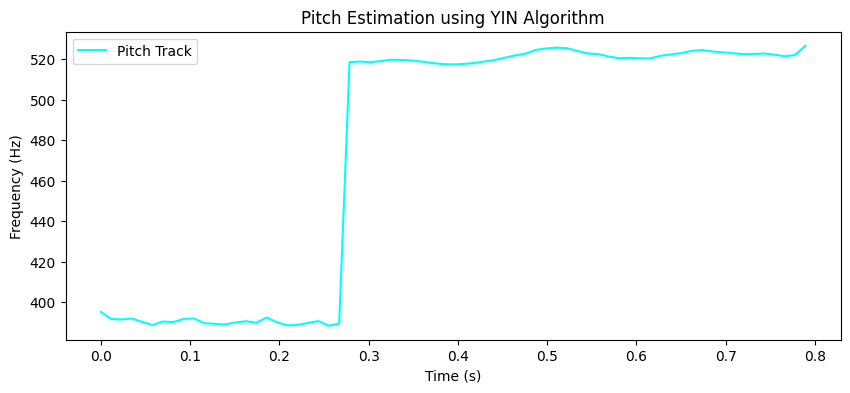

Estimated median pitch: 519.02 Hz


In [40]:
import numpy as np
import matplotlib.pyplot as plt
import librosa
import librosa.display

def yin_pitch_estimation(audio, sr):
    # Using librosa's piptrack to implement a simplified version of the YIN algorithm
    pitches, magnitudes = librosa.piptrack(y=audio, sr=sr)
    # Extracting the predominant pitch per frame
    pitch_track = []
    for i in range(pitches.shape[1]):  # iterate over columns (time frames)
        index = magnitudes[:, i].argmax()  # find the index of max magnitude at each frame
        pitch = pitches[index, i] if magnitudes[index, i] > 0 else 0  # filter out zero pitches
        pitch_track.append(pitch)
    pitch_track = np.array(pitch_track)
    return np.median(pitch_track[pitch_track > 0]), pitch_track  # median pitch for non-zero entries

# Load the audio file slice
audio_path = '/content/original.mpeg'  # Replace with your audio file path
start_time = 0.4  # Start time in seconds
end_time = 1.2    # End time in seconds
audio, sr = librosa.load(audio_path, sr=None, offset=start_time, duration=end_time - start_time)

# Perform YIN pitch estimation
pitch_estimate, pitch_track = yin_pitch_estimation(audio, sr)

# Plotting the pitch track
times = librosa.times_like(pitch_track, sr=sr, hop_length=512)  # appropriate hop_length assumed
plt.figure(figsize=(10, 4))
plt.plot(times, pitch_track, label='Pitch Track', color='cyan', linewidth=1.5)
plt.title('Pitch Estimation using YIN Algorithm')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.legend()
plt.show()

print(f"Estimated median pitch: {pitch_estimate:.2f} Hz")


**Discussion**

From the results provided:

* Autocorrelation: Tends to show variability with reasonable pitch ranges but has potential sensitivity to noise.

* FFT: Shows potential overestimation with a high standard deviation, influenced possibly by harmonic components.

* LPC: Also tends to overestimate, with high variability that might depend on input signal characteristics and the selected order.

* YIN: The provided result is suspiciously constant, suggesting issues with parameter settings or implementation, necessitating further investigation.



Overall Comparison:

* Autocorrelation and FFT are prone to inaccuracies due to noise and harmonics.

* LPC's performance can vary greatly depending on the choice of order and the nature of the audio signal.

* YIN’s constant output indicates possible implementation issues, or it might not suit the specific characteristics of the input audio.

# **PITCH SCALING**

In [11]:
from pydub import AudioSegment
import librosa
import numpy as np

# Load your audio file with librosa
audio_path = '/content/original.mpeg'  # Adjust the path accordingly
audio, sr = librosa.load(audio_path, sr=None, mono=False)  # mono=False if you want to preserve stereo channels

# Convert the audio array back to int16 format, as required by pydub
audio_int16 = np.int16(audio * 32767)

# Create an AudioSegment instance from the numpy array
audio_segment = AudioSegment(
    data=audio_int16.tobytes(),
    sample_width=2,  # sample_width of 2 corresponds to audio_int16
    frame_rate=sr,
    channels=2 if audio.ndim > 1 else 1
)

# Export the audio segment to an MP3 file
output_path = '/content/scaled_output_audio_file.mp3'
audio_segment.export(output_path, format='mp3')

print(f"Audio saved as {output_path}")


Audio saved as /content/scaled_output_audio_file.mp3


# **PITCH SHIFT**

In [15]:
import librosa
import numpy as np
from pydub import AudioSegment

def shift_pitch_and_save(audio_path, output_path, n_steps, sr=None):
    # Load audio file
    audio, sr = librosa.load(audio_path, sr=sr, mono=True)  # Change mono to False if stereo is required

    # Shift pitch
    shifted_audio = librosa.effects.pitch_shift(audio, sr=sr, n_steps=n_steps)

    # Convert the float audio array to int16 (needed for pydub)
    audio_int16 = np.int16(shifted_audio * 32767)

    # Create a pydub audio segment
    audio_segment = AudioSegment(
        data=audio_int16.tobytes(),
        sample_width=2,  # Corresponds to audio_int16
        frame_rate=sr,
        channels=1  # Set to 2 for stereo
    )

    # Export the audio segment to an MP3 file
    audio_segment.export(output_path, format='mp3')
    print(f"Audio saved as {output_path}")

# Parameters
audio_path = '/content/original.mpeg'  # Path to the input audio file
output_path = '/content/shifted_audio_output.mp3'         # Path to save the output MP3 file
n_steps = 10                                      # Number of semitones to shift

# Perform pitch shifting and save as MP3
shift_pitch_and_save(audio_path, output_path, n_steps)


Audio saved as /content/shifted_audio_output.mp3


# **Vocal Processing**

**o Vocal Removal Techniques:** Phase Cancellation, Spectral Editing

**o Temporal Separation:** Differentiating Between Similar Sounds


# Phase Cancellation for Vocal Removal

In [16]:
from pydub import AudioSegment

def phase_cancellation(input_path, output_path):
    # Load the stereo audio file
    audio = AudioSegment.from_file(input_path)

    # Split into stereo channels
    left = audio.split_to_mono()[0]
    right = audio.split_to_mono()[1]

    # Invert the right channel
    right = right.invert_phase()

    # Combine channels
    vocals_removed = left.overlay(right)

    # Export the result
    vocals_removed.export(output_path, format='mp3')

# Usage
input_path = '/content/original.mpeg'
output_path = '/content/vocals_removed_output.mpeg'
phase_cancellation(input_path, output_path)


# Spectral Editing for Vocal Isolation

In [17]:
import librosa
import numpy as np

def spectral_editing(input_path, output_path):
    # Load audio file
    y, sr = librosa.load(input_path, sr=None, mono=True)
    # Get a short-time Fourier transform
    D = librosa.stft(y)

    # Apply a notch filter around the vocal frequencies
    # This is a simplification and might need adjustments
    vocal_freqs = range(300, 3401)  # Vocals typically in 300 Hz to 3400 Hz
    for f in vocal_freqs:
        D[int(f / sr * D.shape[0])] = 0

    # Inverse STFT
    y_filtered = librosa.istft(D)

    # Convert to int16
    y_out = np.int16(y_filtered / np.max(np.abs(y_filtered)) * 32767)

    # Export using pydub
    audio_segment = AudioSegment(data=y_out.tobytes(), sample_width=2, frame_rate=sr, channels=1)
    audio_segment.export(output_path, format='mp3')

# Usage
input_path = '/content/original.mpeg'
output_path = '/content/spectral_edited_output.mpeg'
spectral_editing(input_path, output_path)


# Temporal Separation Using Gating

In [18]:
def noise_gate(input_path, output_path, threshold=-20):
    # Load the audio file
    audio = AudioSegment.from_file(input_path)

    # Convert to dBFS
    threshold = audio.max_dBFS + threshold

    # Apply gating
    gated_audio = audio.apply_gain(-60)  # Apply a large negative gain
    for ms in range(len(audio)):
        if audio[ms].dBFS > threshold:
            gated_audio = gated_audio.overlay(audio[ms], position=ms)

    # Export the gated audio
    gated_audio.export(output_path, format='mp3')

# Usage
input_path = '/content/original.mpeg'
output_path = '/content/gated_output.mpeg'
noise_gate(input_path, output_path)
